In [267]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib import rc
from matplotlib.colors import LinearSegmentedColormap as colormap
from IPython.display import HTML
import functions as f
import os, sys
sys.path.append(os.path.relpath("./src"))
from kitaev_chain import kitaev_chain_model, quench_simulation_bdg, quench_simulation_tfim
from utils import to_n, s0, sx, sy, sz, power_set, tensor_product, canon_eigen, expm, U, c

In [268]:
n = 5
k = 0.01
H0 = kitaev_chain_model(n, k, 1 - k, 1 - k)
H0 = kitaev_chain_model(n, 1, 2, 3)
H0.bdg_eigen()

# Validate $H_{tfim}$ = $\sum_{i}{E_{i}\psi_{i}^{\dagger}\psi_{i}}$

#### Results: Difference between the reconstruction and the JW, may be because of the $\{c_{j},c_{j}^{\dagger}\}$ anticommutation's $\delta_{i}^{j}$ mistreatment

In [315]:
H_bdg = H0.bdg_hamiltonian()

H_tfim_bdg_recon = sum([
    sum([  H_bdg[i][j] * c(i, n, True) @ c(j, n)
         + H_bdg[i + n][j] * c(i, n) @ c(j, n)
         + H_bdg[i][j + n] * c(i, n, True) @ c(j, n, True)
         + H_bdg[i + n][j + n] * c(i, n) @ c(j, n, True)
         for j in range(n)])
     for i in range(n)])
# same as:
H_tfim_bdg =  H0.tfim_hamiltonian_JW_on_bdg()

H_tfim_orig = H0.tfim_hamiltonian_JW_on_orig()
H_tfim_recon = sum([H0.bdg_evals_sorted[i] * (H0.psi(i, dagger=True) @ H0.psi(i)) for i in range(n)])

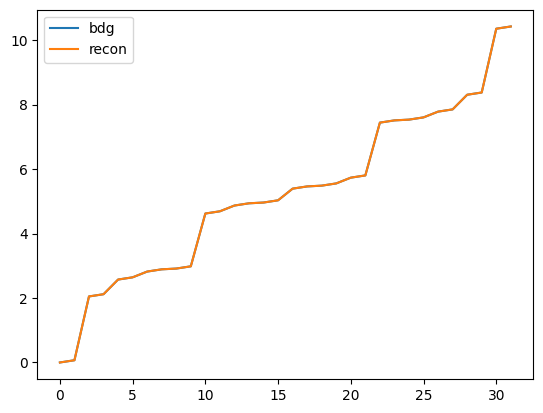

In [317]:
def orthopart(v, Av):
    return Av - v * np.dot(Av, v) / np.linalg.norm(v)

evals1, evecs1 = np.linalg.eigh(H_tfim_bdg)
evals2, evecs2 = np.linalg.eigh(H_tfim_recon)
H_tfim_bdg = 0.5 * (H0.tfim_hamiltonian_JW_on_bdg() - evals1[0] * np.eye(H0.N))
#plt.plot([np.linalg.norm(orthopart(e, H_tfim_recon @ e)) for e in evecs2.T], label='bdg')

#plt.plot([np.dot(e, H_tfim_recon @ e) for e in evecs1.T], label='bdg')
plt.plot(evals1, label='bdg')
plt.plot(evals2, label='recon')
plt.legend()
plt.show()

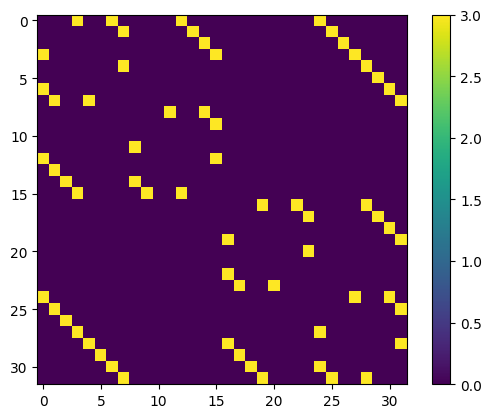

In [ ]:
plt.imshow(np.abs((H_tfim_bdg @ H_tfim_recon - H_tfim_recon @ H_tfim_bdg)))
plt.colorbar()

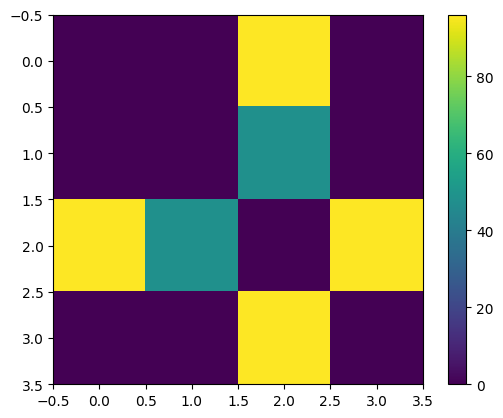

In [272]:
Hs = [H_tfim_bdg, H_tfim_recon, H_tfim_orig, H_tfim_bdg_recon]
corr = [[np.abs(np.linalg.norm(H1 @ H2 - H2 @ H1)) for H1 in Hs] for H2 in Hs]
plt.imshow(corr)
plt.colorbar()

## Vaccum state from G / Intersections

### Test: $\^{\psi}^{\dagger}_{i}\^{\psi}_{i} \^{\psi}^{\dagger}_{j}\ket{vac} = \delta^{j}_{i}\^{\psi}^{\dagger}_{j}\ket{vac}$

### Test: $\^H_{tfim}\^{\psi}^{\dagger}_{j}\ket{vac} = 2E_{j}\^{\psi}^{\dagger}_{j}\ket{vac}$

<>:21: SyntaxWarning: invalid escape sequence '\|'
<>:21: SyntaxWarning: invalid escape sequence '\|'
C:\Users\t-hareldamti\AppData\Local\Temp\ipykernel_17056\1936477865.py:21: SyntaxWarning: invalid escape sequence '\|'
  plt.title("$\|\{\psi_{i},\psi_{j}^{\dagger}\}\|$")


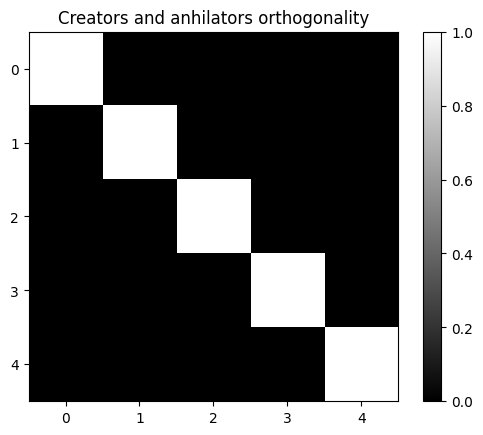

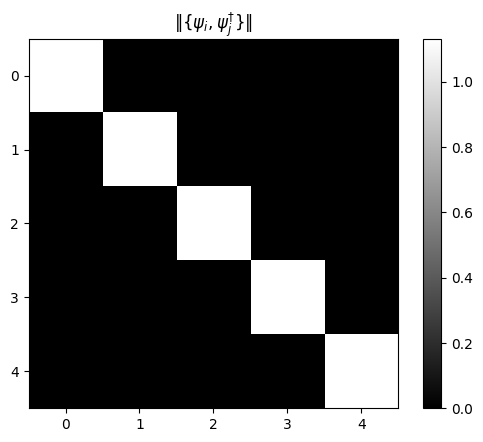

In [299]:
H0.tfim_vac_from_intersections()
H_tfim = H_tfim_bdg
id = np.zeros((n, n)).astype(np.float64)
for i in range(n):
    for j in range(n):
        a = H0.psi(i, dagger=True) @ H0.psi(i) @ H0.psi(j, dagger=True) @ H0.vac
        id[i, j] = np.linalg.norm(a)
plt.imshow(np.abs(id), cmap='gray')
plt.colorbar()
plt.title("Creators and anhilators orthogonality")
plt.show()

id = np.zeros((n, n)).astype(np.float64)
for i in range(n):
    for j in range(n):
        a = H0.psi(j, dagger=True) @ H0.psi(i)
        b = H0.psi(i) @ H0.psi(j, dagger=True)
        id[i, j] = np.linalg.norm(a + b) / n
plt.imshow(np.abs(id), cmap='gray')
plt.colorbar()
plt.title("$\|\{\psi_{i},\psi_{j}^{\dagger}\}\|$")
plt.show()


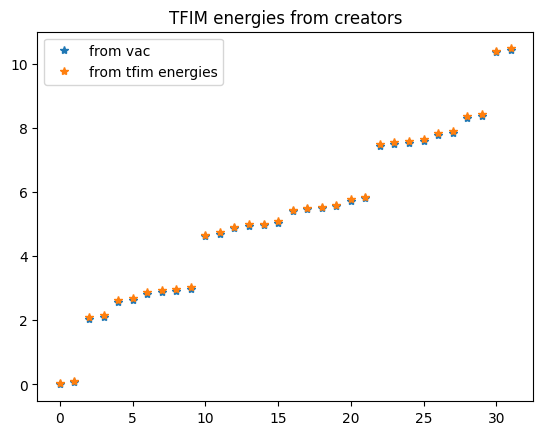

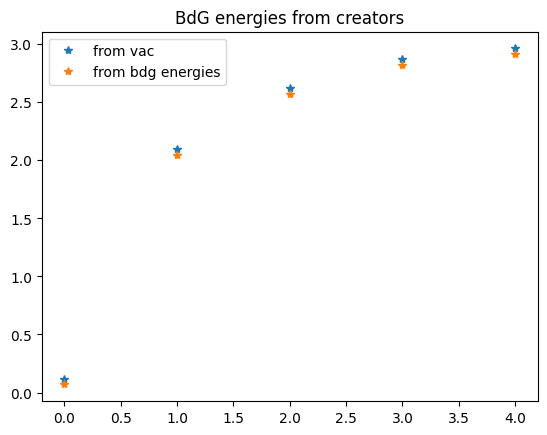

In [300]:
subsets = [[i for i in range(n) if l[i]] for l in power_set(n)]
states = []
for subset in subsets:
    psi_ = H0.vac
    for i in subset:
        psi_ = H0.psi(i, dagger=True) @ psi_
    states.append(psi_)
evals_comp_from_vac = [np.linalg.norm(psi_.T @ H_tfim @ psi_) for psi_ in states]
evals_comp, evecs_comp = np.linalg.eigh(H_tfim)
plt.plot(sorted(evals_comp_from_vac), '*', label='from vac')
plt.plot((sorted(evals_comp) - min(evals_comp) + .05), '*', label='from tfim energies')
plt.legend()
plt.title("TFIM energies from creators")
plt.show()

psi_vac = [H0.psi(i, dagger=True) @ H0.vac for i in range(n)]
evals_vac = np.array([np.abs(psi_.T @ H_tfim @ psi_)[0, 0] for psi_ in psi_vac])
plt.plot((evals_vac + .05), '*', label='from vac')
plt.plot(H0.bdg_evals_sorted[:n], '*', label='from bdg energies')
plt.legend()
plt.title("BdG energies from creators")
plt.show()

c:\Users\t-hareldamti\Documents\University\Research Project\Anyons\univ-proj-physics-bsc\.venv\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\t-hareldamti\Documents\University\Research Project\Anyons\univ-proj-physics-bsc\.venv\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


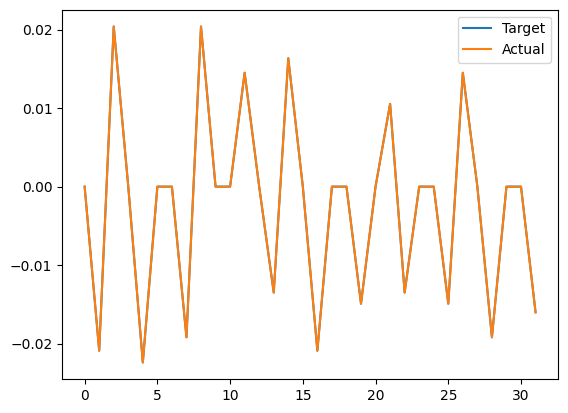

In [302]:
i = 0
psi_ = H0.psi(i, dagger=True) @ H0.vac
H0_psi_ = (H_tfim_bdg) @ psi_
plt.plot(H0.bdg_evals_sorted[i] * psi_, label="Target")
plt.plot(H0_psi_, label="Actual")
plt.legend()

## Loschmidt amplitude

U, V numerical incompabillity


c:\Users\t-hareldamti\Documents\University\Research Project\Anyons\univ-proj-physics-bsc\.venv\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\t-hareldamti\Documents\University\Research Project\Anyons\univ-proj-physics-bsc\.venv\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


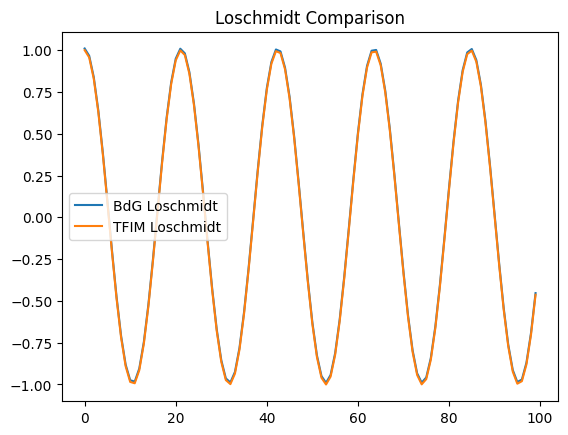

In [303]:
eigenvalue_index = [0, 1, 2, 3]
k = 1e-2
H = kitaev_chain_model(n, k, 1 - k, 1 - k)
H.bdg_eigen()
H.tfim_vac_from_intersections()
U_bdg = U(H.bdg_hamiltonian())

H1 = sum([H.bdg_evals_sorted[i] * H.psi(i, dagger=True) @ H.psi(i) for i in range(n)])
U_tfim = U(H1)

H_tfim = H.tfim_hamiltonian_JW_on_bdg()
tfim_energies, _ = np.linalg.eigh(H_tfim)
U_tfim = U(0.5 * (H_tfim - tfim_energies[0] * np.eye(H.N)))

dt = 0.1
duration = 10
t_range = np.arange(0, duration, dt)

L_bdg = np.array([np.linalg.det(H.bdg_evecs_sorted[:, eigenvalue_index].T.conj() @ U_bdg(t) @ H.bdg_evecs_sorted[:, eigenvalue_index]) for t in t_range])

L_initial = np.hstack([H.psi(i, dagger=True) @ H.vac for i in eigenvalue_index])
L_tfim = np.array([np.linalg.det(L_initial.T.conj() @ U_tfim(t) @ L_initial) for t in t_range])

plt.plot(L_bdg + .01, label="BdG Loschmidt")
plt.plot(L_tfim, label="TFIM Loschmidt")
plt.title("Loschmidt Comparison")
plt.legend()
plt.show()